In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos import *

In [2]:
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set np.random seed
np.random.seed(2027)

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 2.7.14+ (default, Apr 19 2019, 15:48:06) [GCC 7.4.1 20190129]
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Settings

zone = 0

#nevents = 200000
nevents = -1

# Input files
signal = 'signal_add.1.npz'
bkgnd = 'bkgnd_add.1.npz'

# Image format
num_channels = 3
num_cols = 300
num_rows = 10
image_format = (num_rows, num_cols, num_channels)

# Parameter
num_pars = 5

# q/pT and d0 binning
#invpt_bins = np.array([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
#dzero_bins = np.array([-150., -90., -30., 30., 90., 150.])

# Customise
if zone == 0:
  pref_row = 4
  invpt_bins = np.array([-0.49277655, -0.24515343, -0.06501561, 0.06501561, 0.24515343, 0.49277655])
  dzero_bins = np.array([-149.01635796, -80.24550629, -19.69444885, 19.69444885, 80.24550629, 149.01635796])
elif zone == 1:
  pref_row = 5
  invpt_bins = np.array([-0.49370697, -0.26011642, -0.07240327, 0.07240327, 0.26011642, 0.49370697])
  dzero_bins = np.array([-148.42751366, -75.90176582, -18.08490837, 18.08490837, 75.90176582, 148.42751366])
elif zone == 2:
  pref_row = 3
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
elif zone == 3:
  pref_row = 6
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
else:
  raise RuntimeError('Cannot recognize zone: {0}'.format(zone))

# Labels
zone_row_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1', 'none' ],
  ['GE1/1', 'ME1/1', 'ME1/2', 'RE1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2', 'none' , 'none' ],
  ['MB1'  , 'MB2'  , 'MB3'  , 'ME1/3', 'RE1/3', 'RE2/3', 'ME2/2', 'ME3/2', 'RE3/3', 'ME4/2'],
]

logger.info('Processing zone {0}'.format(zone))
logger.info('.. nevents      : {0}'.format(nevents))
logger.info('.. image_format : {0}'.format(image_format))
logger.info('.. pref_row     : {0}'.format(pref_row))
logger.info('.. invpt_bins   : {0}'.format(invpt_bins))
logger.info('.. dzero_bins   : {0}'.format(dzero_bins))

[INFO    ] Processing zone 0
[INFO    ] .. nevents      : -1
[INFO    ] .. image_format : (10, 300, 3)
[INFO    ] .. pref_row     : 4
[INFO    ] .. invpt_bins   : [-0.49277655 -0.24515343 -0.06501561  0.06501561  0.24515343  0.49277655]
[INFO    ] .. dzero_bins   : [-149.01635796  -80.24550629  -19.69444885   19.69444885   80.24550629
  149.01635796]


In [4]:
# Binning functions

def my_digitize(x, bins):
  # first and last bins include underflow and overflow
  ind = np.searchsorted(bins, x)
  ind = np.clip(ind-1, 0, len(bins)-2)  # starts from 0
  return ind

def find_par_row_col(par):
  (invpt, d0, eta, phi, invpt2) = par
  ind0 = my_digitize(invpt2, invpt_bins)
  ind1 = my_digitize(d0, dzero_bins)
  return (ind1, ind0)

### Load data

In [5]:
def load_signal(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    logger.info('out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(f):
  logger.info('Loading from {0}'.format(f))
  with np.load(f) as loaded:
    out_aux = loaded['out_aux']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    logger.info('out_aux: {0} out_hits: {1}'.format(out_aux.shape, out_hits.shape))
  return (out_aux, out_hits)

In [6]:
part_arrays, hits_arrays, simhits_arrays = load_signal(signal)
aux_arrays, bkghits_arrays = load_bkgnd(bkgnd)

[INFO    ] Loading from signal_add.1.npz
[INFO    ] out_part: (2275023, 9) out_hits: (2275023, None, 9) out_simhits: (2275023, None, 9)
[INFO    ] Loading from bkgnd_add.1.npz
[INFO    ] out_aux: (16235292, 3) out_hits: (16235292, None, 9)


In [7]:
# Debug
print(part_arrays[0], hits_arrays[0], simhits_arrays[0])
print(part_arrays[1], hits_arrays[1], simhits_arrays[1])
print(part_arrays[2], hits_arrays[2], simhits_arrays[2])
print(part_arrays[3], hits_arrays[3], simhits_arrays[3])

[ -0.07286745   1.981351     2.1438558   24.857655   -25.86196
   1.2163241    6.3448358    1.           0.        ] [[   0    0  246 4267   14   12    0   -1    0]
 [   0    3  255 4404    0   18    0    0    0]
 [   0    4  255 4413    2   18    0   -1    0]
 [   0    5  256 4431    1   18    0    1    0]
 [   0    6  257 4433    0   19    0    1    1]
 [   0    7  257 4440    0   19   19    1    0]
 [   0    8  257 4446    0   19    0    0    0]] [[   0    0  246 4264    0   13    0    0    0]
 [   0    2  250 4324    0   14    0    0    0]
 [   0    3  255 4404    0   17    0    0    0]
 [   0    4  255 4413    0   18    0    0    0]
 [   0    5  256 4428    0   18    0    0    0]
 [   0    6  257 4434    0   19    0    0    0]
 [   0    7  257 4440    0   19    0    0    0]
 [   0    8  257 4445    0   19    0    0    0]]
[1.6307077e-01 1.5877699e+00 7.2498721e-01 1.7160455e+02 1.0059981e+02
 6.9927592e+00 7.0719070e+01 0.0000000e+00 2.0000000e+00] [[   2    2  130 2408    0   88 

### Build images

In [8]:
# Parse particles & hits

import numba

@numba.njit
def fill_param_array(part_array, param_array):
  # read
  invpt = part_array[0]
  eta = part_array[1]
  phi = part_array[2]
  vx = part_array[3]
  vy = part_array[4]
  vz = part_array[5]
  d0 = part_array[6]
  sector = part_array[7]
  zone = part_array[8]
  # write
  param_array[:] = (invpt, d0, eta, phi, invpt)
  return

def get_part_zone(part_array):
  zone = part_array[8]
  return zone.astype(np.int32)

@numba.njit
def fill_image(hit_array, image):
  # read
  zone = hit_array[0]
  zone_row = hit_array[1]
  zone_col = hit_array[2]
  emtf_phi = hit_array[3]
  emtf_bend = hit_array[4]
  emtf_theta = hit_array[5]
  emtf_theta_alt = hit_array[6]
  emtf_qual = hit_array[7]
  emtf_time = hit_array[8]
  # write
  row = zone_row
  col = zone_col
  ch0 = 1
  ch1 = (emtf_phi - min_emtf_strip) - (zone_col * coarse_emtf_strip)
  ch2 = emtf_bend + 128
  ## assert
  #assert(0 <= zone_col < num_cols)
  #assert(0 <= ch0 < 256)
  #assert(0 <= ch1 < 256)
  #assert(0 <= ch2 < 256)
  image[row, col] = (ch0, ch1, ch2)
  return

def get_hit_zone(hit_array):
  zone = hit_array[0]
  return zone.astype(np.int32)

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numba/0.43.1-pafccj/lib/python2.7/site-packages/numba/__init__.py:78: UserWarning: llvmlite version format not recognized!
  warnings.warn("llvmlite version format not recognized!")


In [9]:
def build_images(part_arrays, hits_arrays, simhits_arrays):
  # Reserve arrays
  _capacity = 540000
  images = np.zeros((_capacity, num_rows, num_cols, num_channels), dtype=np.uint8)
  images_gt = np.zeros((_capacity, num_rows, num_cols, num_channels), dtype=np.uint8)
  params_gt = np.zeros((_capacity, num_pars), dtype=np.float32)
  print('Successfully reserved huge arrays.')

  cnt = 0

  # Loop over (part_arrays, hits_arrays, simhits_arrays)
  for ievt, (part_array, hits_array, simhits_array) in enumerate(zip(part_arrays, hits_arrays, simhits_arrays)):
    if ievt == nevents or cnt == _capacity:
      break

    if (ievt%100000) == 0:
      print('Processing event {0}'.format(ievt))

    # Skip if particle not in this zone
    if get_part_zone(part_array) != zone:
      continue

    # Fill images
    for hit_array in hits_array:
      # Skip if hit not in this zone
      if get_hit_zone(hit_array) != zone:
        continue
      fill_image(hit_array, images[cnt])

    # Fill images_gt
    for simhit_array in simhits_array:
      # Skip if hit not in this zone
      if get_hit_zone(simhit_array) != zone:
        continue
      fill_image(simhit_array, images_gt[cnt])

    # Fill params_gt
    fill_param_array(part_array, params_gt[cnt])

    # Count
    cnt += 1

  # Resize arrays
  images.resize((cnt, num_rows, num_cols, num_channels))
  images_gt.resize((cnt, num_rows, num_cols, num_channels))
  params_gt.resize((cnt, num_pars))
  return (images, images_gt, params_gt)

In [10]:
%%time

images, images_gt, params_gt = build_images(part_arrays, hits_arrays, simhits_arrays)

Successfully reserved huge arrays.
Processing event 0
Processing event 100000
Processing event 200000
Processing event 300000
Processing event 400000
Processing event 500000
Processing event 600000
Processing event 700000
Processing event 800000
Processing event 900000
Processing event 1000000
Processing event 1100000
Processing event 1200000
Processing event 1300000
Processing event 1400000
Processing event 1500000
Processing event 1600000
Processing event 1700000
Processing event 1800000
Processing event 1900000
Processing event 2000000
Processing event 2100000
Processing event 2200000
CPU times: user 46.7 s, sys: 5.31 s, total: 52 s
Wall time: 51.6 s


In [11]:
# Debug
print(len(images), len(images_gt), len(params_gt))
print(images[0].shape, images_gt[0].shape, params_gt[0].shape)

print(images[0][np.nonzero(images[0][...,0])])
print(images[1][np.nonzero(images[1][...,0])])
print(images[2][np.nonzero(images[2][...,0])])
print(images[3][np.nonzero(images[3][...,0])])

538940 538940 538940
(10, 300, 3) (10, 300, 3) (5,)
[[  1  11 142]
 [  1   4 128]
 [  1  13 130]
 [  1  15 129]
 [  1   1 128]
 [  1   8 128]
 [  1  14 128]]
[[  1  13 128]
 [  1  12 137]
 [  1   7 132]
 [  1   8 133]
 [  1  10 128]
 [  1   2 129]
 [  1   1 128]]
[[  1  10 121]
 [  1   1 120]
 [  1   8 120]]
[[  1  13 128]
 [  1   9 129]]


In [12]:
# Additional filters
# Require at least 1 hit in station ME2 (a.k.a. preferred row) and at least 1 hit in 3 different stations

pref_row_nonzero = np.any(images_gt[:, pref_row, :, 0], axis=1)
#print(pref_row_nonzero.shape)
at_least_3_rows_nonzero = np.sum(np.any(images_gt[:, :, :, 0], axis=2), axis=1) >= 3
#print(at_least_3_rows_nonzero.shape)

images = images[pref_row_nonzero & at_least_3_rows_nonzero]
images_gt = images_gt[pref_row_nonzero & at_least_3_rows_nonzero]
params_gt = params_gt[pref_row_nonzero & at_least_3_rows_nonzero]

In [13]:
# Debug
print(len(images), len(images_gt), len(params_gt))
print(images[0].shape, images_gt[0].shape, params_gt[0].shape)

print(images[0][np.nonzero(images[0][...,0])])
print(images[1][np.nonzero(images[1][...,0])])
print(images[2][np.nonzero(images[2][...,0])])
print(images[3][np.nonzero(images[3][...,0])])

428729 428729 428729
(10, 300, 3) (10, 300, 3) (5,)
[[  1  11 142]
 [  1   4 128]
 [  1  13 130]
 [  1  15 129]
 [  1   1 128]
 [  1   8 128]
 [  1  14 128]]
[[  1  13 128]
 [  1  12 137]
 [  1   7 132]
 [  1   8 133]
 [  1  10 128]
 [  1   2 129]
 [  1   1 128]]
[[  1  10 121]
 [  1   1 120]
 [  1   8 120]]
[[  1   7 108]
 [  1  11 123]
 [  1  10 128]
 [  1   8 128]
 [  1   0 128]
 [  1  13 128]
 [  1   5 128]]


In [14]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

In [15]:
# Display image

def display_image(zone, img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zone_row_labels[zone])))
  ax.set_yticklabels(zone_row_labels[zone], fontsize=7)
  plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


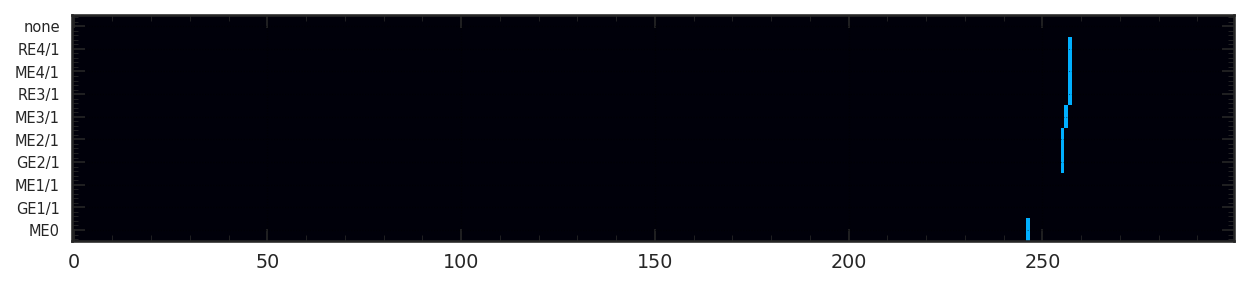

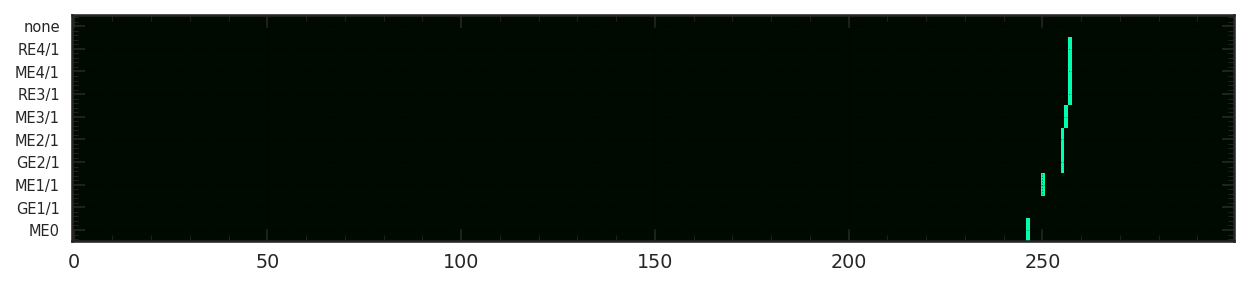

(array([0, 3, 4, 5, 6, 7, 8]), array([246, 255, 255, 256, 257, 257, 257]))
(array([0, 2, 3, 4, 5, 6, 7, 8]), array([246, 250, 255, 255, 256, 257, 257, 257]))


In [16]:
ievt = 0
display_image(zone, images[ievt])
display_image(zone, images_gt[ievt], cmap=green_hot)

print(np.nonzero(images[ievt][...,0]))
print(np.nonzero(images_gt[ievt][...,0]))

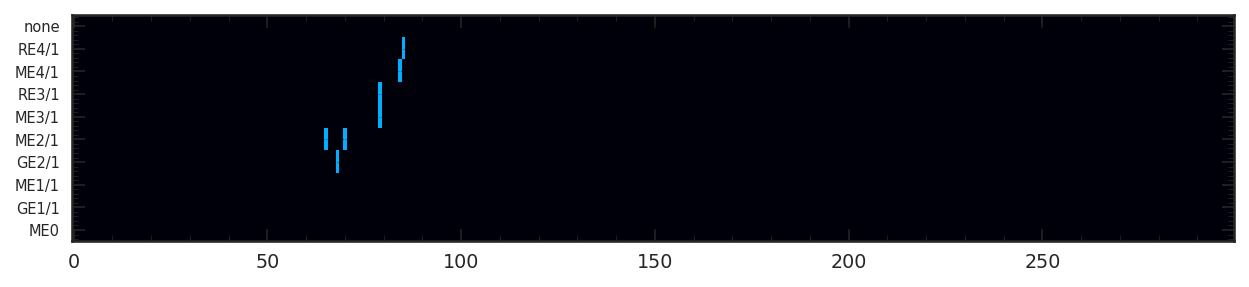

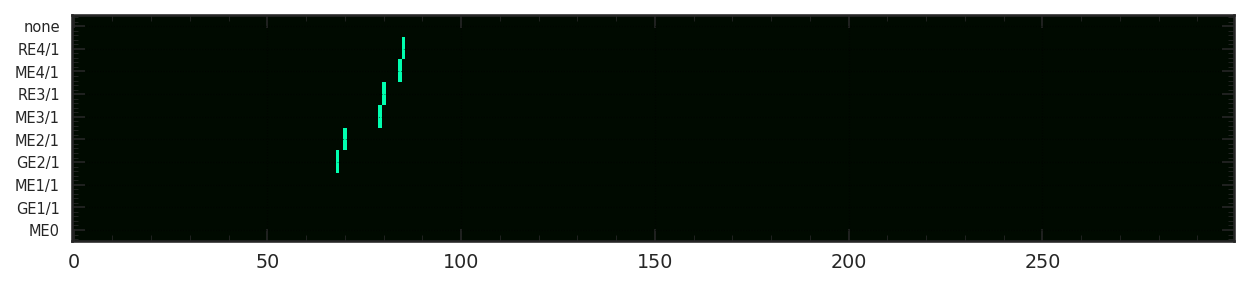

(array([3, 4, 4, 5, 6, 7, 8]), array([68, 65, 70, 79, 79, 84, 85]))
(array([3, 4, 5, 6, 7, 8]), array([68, 70, 79, 80, 84, 85]))


In [17]:
ievt = 1
display_image(zone, images[ievt])
display_image(zone, images_gt[ievt], cmap=green_hot)

print(np.nonzero(images[ievt][...,0]))
print(np.nonzero(images_gt[ievt][...,0]))

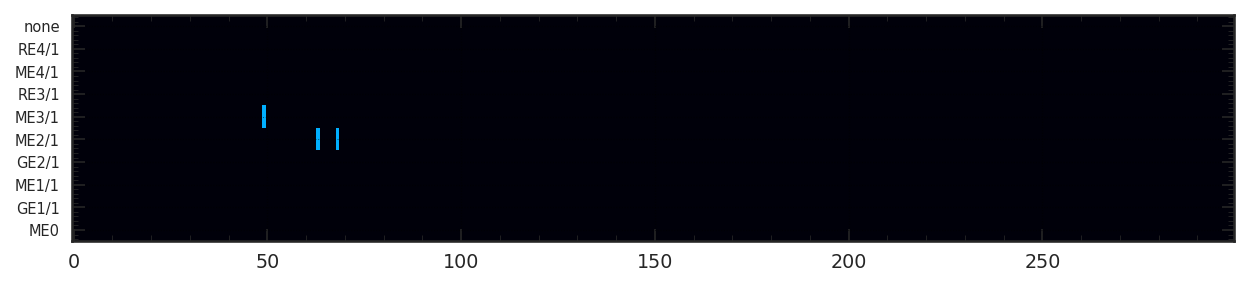

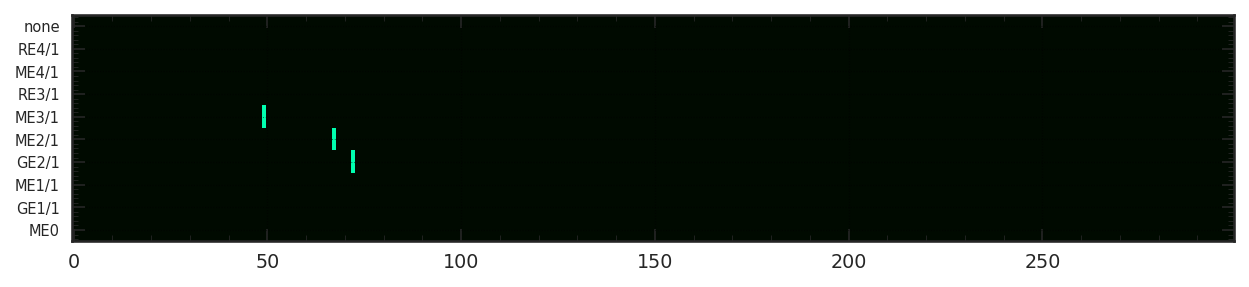

(array([4, 4, 5]), array([63, 68, 49]))
(array([3, 4, 5]), array([72, 67, 49]))


In [18]:
ievt = 2
display_image(zone, images[ievt])
display_image(zone, images_gt[ievt], cmap=green_hot)

print(np.nonzero(images[ievt][...,0]))
print(np.nonzero(images_gt[ievt][...,0]))

In [19]:
# Quick check

pref_cols = []
pref_cols_ch0 = []
pref_cols_ch1 = []
pref_cols_ch2 = []

for img_gt in images_gt[:10000]:
  pref_col = np.argmax(img_gt[pref_row, :][...,0])
  pref_cols.append(pref_col)
  pref_cols_ch0.append(img_gt[pref_row, pref_col, 0]/1.)
  pref_cols_ch1.append(img_gt[pref_row, pref_col, 1]/15.)
  pref_cols_ch2.append(img_gt[pref_row, pref_col, 2]-128.)

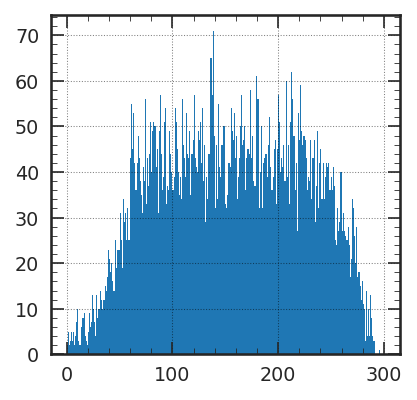

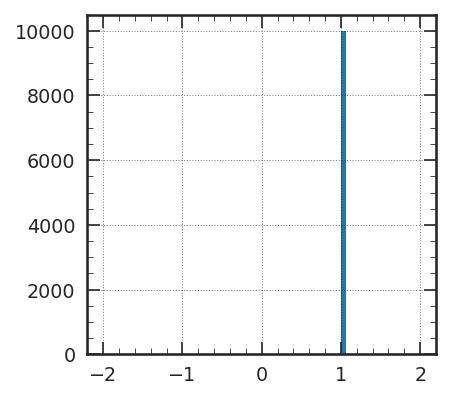

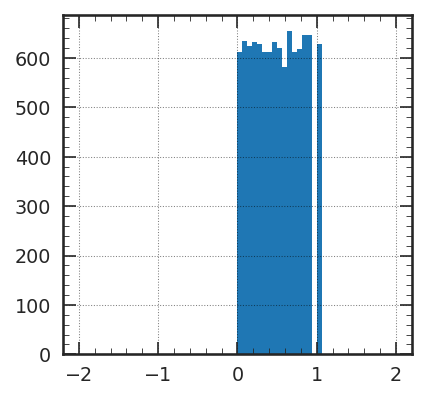

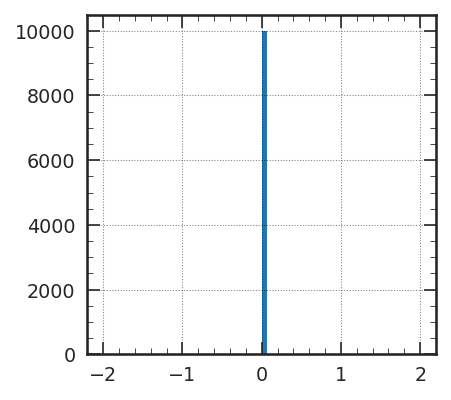

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols, range=(0,num_cols), bins=num_cols)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols_ch0, range=(-2,2), bins=64)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols_ch1, range=(-2,2), bins=64)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(pref_cols_ch2, range=(-2,2), bins=64)
plt.show()

In [21]:
# Quick check

invpt_vals = []
dzero_vals = []

for par in params_gt:
  (invpt, d0, eta, phi, invpt2) = par
  if np.abs(d0) <= 20.:
    invpt_vals.append(invpt2)
    invpt_vals.append(-invpt2)
  if np.abs(1.0/invpt2) >= 20.:
    dzero_vals.append(d0)
    dzero_vals.append(-d0)

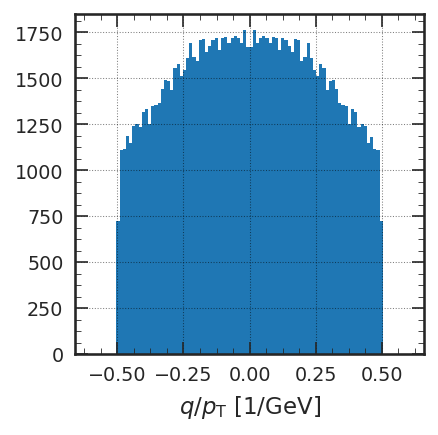

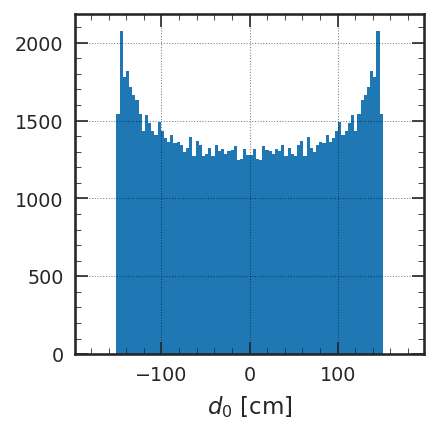

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(invpt_vals, range=(-0.6,0.6), bins=100)
ax.set_xlabel(r'$q/p_{\mathrm{T}}$ [1/GeV]')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist(dzero_vals, range=(-180,180), bins=100)
ax.set_xlabel(r'$d_{0}$ [cm]')
plt.show()

In [23]:
#print('invpt binning: {0}'.format(np.percentile(invpt_vals, [0.5,20,40,60,80,99.5], overwrite_input=True)))
#print('d0 binning: {0}'.format(np.percentile(dzero_vals, [0.5,20,40,60,80,99.5], overwrite_input=True)))

print('invpt binning: {0}'.format(np.percentile(invpt_vals, [0.5,22.5,42.5,57.5,77.5,99.5], overwrite_input=True)))
print('d0 binning: {0}'.format(np.percentile(dzero_vals, [0.5,25,44,56,75,99.5], overwrite_input=True)))

invpt binning: [-0.49306814 -0.24620399 -0.06596502  0.06596502  0.24620399  0.49306814]
d0 binning: [-149.05425911  -81.99509811  -19.97518654   19.97518654   81.99509811
  149.05425911]


In [24]:
# Quick check

invpt_vals = []
dzero_vals = []

for par in params_gt:
  (invpt, d0, eta, phi, invpt2) = par
  invpt_vals.append(invpt2)
  dzero_vals.append(d0)

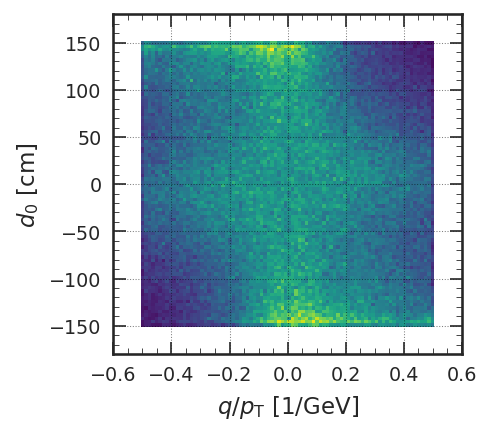

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
_ = ax.hist2d(invpt_vals, dzero_vals, range=((-0.6,0.6),(-180,180)), bins=(100,100),
              cmap=my_cmap, vmin=1)
ax.set_xlabel(r'$q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$d_{0}$ [cm]')
plt.show()

### Boxes

In [26]:
do_boxes = True

num_box_rows = num_rows

num_box_cols = 99

num_box_channels = 1

box_col_offset = 49

num_par_rows = len(invpt_bins)-1

num_par_cols = len(dzero_bins)-1

def build_boxes():
  # 5 indices: (par_row, par_col, box_row, box_col, box_channel)
  boxes = np.zeros((num_par_rows, num_par_cols, num_box_rows, num_box_cols, num_box_channels), dtype=np.float32)

  # Note: using images_gt
  for i, (img, par) in enumerate(zip(images_gt, params_gt)):
    if (i%10000) == 0:
      print('Building image {0}'.format(i))

    pref_col = np.argmax(img[pref_row, :][...,0])
    rows, cols = np.nonzero(img[...,0])

    par_row, par_col = find_par_row_col(par)
    mirror_par_row, mirror_par_col = (num_par_rows-1) - par_row, (num_par_cols-1) - par_col

    for row, col in zip(rows, cols):
      # canon image
      col = (col - pref_col) + box_col_offset
      if 0 <= col < num_box_cols:
        boxes[par_row, par_col, row, col] += 1.0
      # mirror image
      mirror_col = (num_box_cols-1) - col
      if 0 <= mirror_col < num_box_cols:
        boxes[mirror_par_row, mirror_par_col, row, mirror_col] += 1.0
  return boxes

In [27]:
%%time

if do_boxes:
  boxes = build_boxes()
  boxes_orig = boxes.copy()

Building image 0
Building image 10000
Building image 20000
Building image 30000
Building image 40000
Building image 50000
Building image 60000
Building image 70000
Building image 80000
Building image 90000
Building image 100000
Building image 110000
Building image 120000
Building image 130000
Building image 140000
Building image 150000
Building image 160000
Building image 170000
Building image 180000
Building image 190000
Building image 200000
Building image 210000
Building image 220000
Building image 230000
Building image 240000
Building image 250000
Building image 260000
Building image 270000
Building image 280000
Building image 290000
Building image 300000
Building image 310000
Building image 320000
Building image 330000
Building image 340000
Building image 350000
Building image 360000
Building image 370000
Building image 380000
Building image 390000
Building image 400000
Building image 410000
Building image 420000
CPU times: user 33.4 s, sys: 1.65 s, total: 35 s
Wall time: 35 s


In [28]:
# Debug

if do_boxes:
  with np.printoptions(precision=3) as opts:
    print(boxes[2, 2, :, box_col_offset-5:box_col_offset+6, 0])

[[  363.   349.   333.   397.   344.   350.   344.   397.   333.   349.
    363.]
 [  251.   278.   267.   297.   312.   278.   312.   297.   267.   278.
    251.]
 [  536.   628.   709.   725.   728.   748.   728.   725.   709.   628.
    536.]
 [    0.    22.   119.   672.  3612.  8686.  3612.   672.   119.    22.
      0.]
 [    0.     0.     0.     0.     0. 18326.     0.     0.     0.     0.
      0.]
 [  216.   467.   945.  1918.  3216.  3582.  3216.  1918.   945.   467.
    216.]
 [  318.   625.  1148.  2047.  2564.  2706.  2564.  2047.  1148.   625.
    318.]
 [  529.   780.  1288.  1711.  1912.  1870.  1912.  1711.  1288.   780.
    529.]
 [  587.   884.  1331.  1575.  1673.  1632.  1673.  1575.  1331.   884.
    587.]
 [    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.]]


In [29]:
# Apply anti-aliasing and normalization

@numba.njit
def njit_pad_image(img, img_padded, pad_l, pad_t):
  # based on pytorch nn.ReflectionPad2d
  for i in range(img_padded.shape[0]):
    if i < pad_t:
      ip_y = pad_t * 2 - i
    elif i >= img.shape[0] + pad_t:
      ip_y = (img.shape[0] + pad_t - 1) * 2 - i
    else:
      ip_y = i
    ip_y = ip_y - pad_t

    for j in range(img_padded.shape[1]):
      if j < pad_l:
        ip_x = pad_l * 2 - j
      elif j >= img.shape[1] + pad_l:
        ip_x = (img.shape[1] + pad_l - 1) * 2 - j
      else:
        ip_x = j
      ip_x = ip_x - pad_l

      # Padding
      img_padded[i, j] = img[ip_y, ip_x]
      #print((i,j), (ip_y,ip_x))

@numba.njit
def njit_apply_filter(img, img_padded, filt, pad_l, pad_t):
  for i in range(img_padded.shape[0]):
    for j in range(img_padded.shape[1]):
      if i >= pad_t and i < img.shape[0] + pad_t:
        if j >= pad_l and j < img.shape[1] + pad_l:
          ip_y = i - pad_t
          ip_x = j - pad_l

          # Receptive field of filter
          field = img_padded[i-pad_t:i+pad_t+1, j-pad_l:j+pad_l+1]

          # Matrix multiplication
          if field.sum() > 0.:
            #img[ip_y, ip_x] = np.sum(filt * field)
            for k in range(filt.shape[0]):
              for kk in range(filt.shape[1]):
                for kkk in range(filt.shape[2]):
                  img[ip_y, ip_x] += (filt[k, kk, kkk] * field[k, kk, kkk])

# Reference:
#   https://github.com/adobe/antialiased-cnns
#   https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/ReflectionPad.cpp

class Antialiaser(object):
  def __init__(self):
    self.filt_size = 3
    self.pad_l = 1
    self.pad_t = 0

    box_shape = (num_box_rows, num_box_cols, num_box_channels)
    old_shape = box_shape
    new_shape = (old_shape[0] + self.pad_t * 2, old_shape[1] + self.pad_l * 2, old_shape[2])
    self.img_orig = np.zeros(old_shape, dtype=np.float32)
    self.img_padded = np.zeros(new_shape, dtype=np.float32)

    self.filt = np.array([1., 2., 1.])  # 1D
    #self.filt = np.array([1., 4., 1.])  # 1D
    self.filt = self.filt / np.sum(self.filt)
    self.filt = self.filt.reshape(1, self.filt_size, 1)

  def __call__(self, img):
    self.img_orig *= 0
    self.img_orig += img

    self.img_padded *= 0

    # Add padding
    njit_pad_image(img, self.img_padded, self.pad_l, self.pad_t)

    # Apply filter
    njit_apply_filter(img, self.img_padded, self.filt, self.pad_l, self.pad_t)

    # Remove anti-aliasing on pref_row
    #img[pref_row, :] = self.img_orig[pref_row, :]
    return img

# As function
antialias_image = Antialiaser()

class Normalizer(object):
  def __call__(self, img):
    norm = np.sqrt(np.square(img).sum(axis=-2, keepdims=True))
    norm[norm == 0] = 1.0
    img /= norm
    img[img < 1e-2] = 0.0
    return img

# As function
normalize_image = Normalizer()

def display_boxes(zone, boxes_orig, boxes, cmap=blue_hot, figsize=(10,10)):
  fig, axs = plt.subplots(num_par_rows, num_par_cols, figsize=figsize, tight_layout=True, sharex=True, sharey=True)
  for i in range(num_par_rows):
    for j in range(num_par_cols):
      ax = axs[(num_par_rows-1)-i, j]  # axs[0,0] is top left
      img_orig = boxes_orig[i, j]
      img = boxes[i, j]
      antialias_image(img)
      normalize_image(img)
      print(i, j, img_orig.sum(), img.sum())
      ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto')
      ax.set_xticklabels([])
      ax.set_yticklabels([])
      ax.grid(False)
  plt.show()

0 0 158510.0 39.69494
0 1 221932.0 40.0254
0 2 222430.0 41.72915
0 3 265537.0 39.737526
0 4 269397.0 38.092026
1 0 243974.0 39.593254
1 1 242535.0 37.922447
1 2 194201.0 39.013805
1 3 242558.0 38.831833
1 4 238771.0 39.197594
2 0 194358.0 36.487534
2 1 170844.0 30.897594
2 2 125274.0 29.877892
2 3 170844.0 30.89759
2 4 194358.0 36.487534
3 0 238771.0 39.197594
3 1 242558.0 38.831833
3 2 194201.0 39.013805
3 3 242535.0 37.922443
3 4 243974.0 39.593254
4 0 269397.0 38.092026
4 1 265537.0 39.737526
4 2 222430.0 41.72915
4 3 221932.0 40.0254
4 4 158510.0 39.69494


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


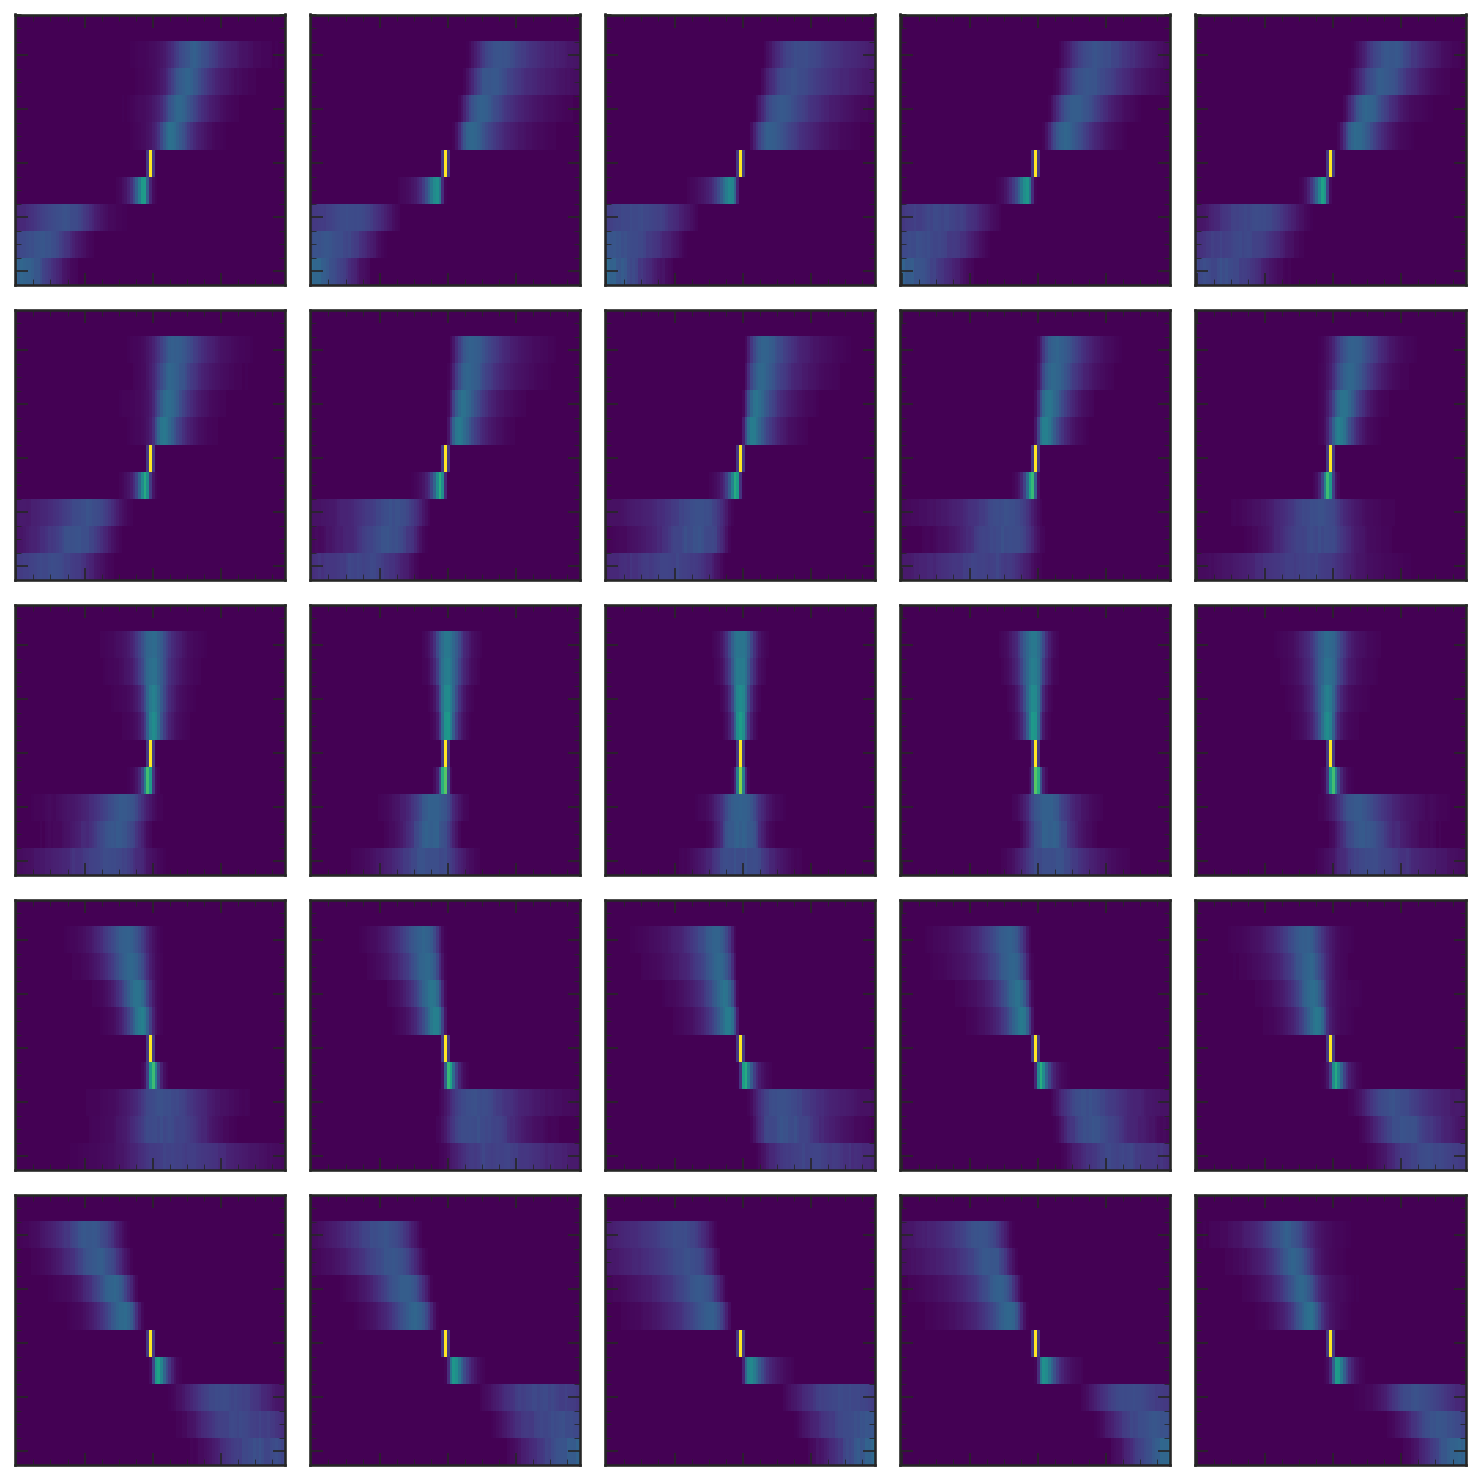

In [30]:
if do_boxes:
  boxes[:] = boxes_orig
  display_boxes(zone, boxes_orig, boxes)

In [31]:
# Debug

if do_boxes:
  with np.printoptions(precision=3) as opts:
    print(boxes[2, 2, :, box_col_offset-5:box_col_offset+6, 0])

[[0.232 0.225 0.221 0.247 0.227 0.225 0.227 0.247 0.221 0.225 0.232]
 [0.248 0.272 0.271 0.294 0.305 0.285 0.305 0.294 0.271 0.272 0.248]
 [0.219 0.257 0.288 0.297 0.3   0.305 0.3   0.297 0.288 0.257 0.219]
 [0.    0.    0.019 0.104 0.416 0.795 0.416 0.104 0.019 0.    0.   ]
 [0.    0.    0.    0.    0.162 0.973 0.162 0.    0.    0.    0.   ]
 [0.036 0.077 0.156 0.303 0.48  0.54  0.48  0.303 0.156 0.077 0.036]
 [0.06  0.116 0.212 0.354 0.446 0.473 0.446 0.354 0.212 0.116 0.06 ]
 [0.115 0.174 0.274 0.361 0.403 0.403 0.403 0.361 0.274 0.174 0.115]
 [0.136 0.206 0.297 0.355 0.377 0.374 0.377 0.355 0.297 0.206 0.136]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


In [32]:
if do_boxes:
  # Write
  outfile = 'boxes_zone%i.npz' % zone
  save_np_arrays(outfile, dict(boxes=boxes, boxes_orig=boxes_orig))
  logger.info('Wrote to {0}'.format(outfile))
else:
  # Read
  infile = 'boxes_zone%i.1.npz' % zone
  logger.info('Loading from {0}'.format(infile))
  with np.load(infile) as f:
    boxes = f['boxes']
    boxes_orig = f['boxes_orig']

[INFO    ] Wrote to boxes_zone0.npz


### Annotations

In [33]:
do_annotations = False

@numba.njit
def njit_annotate_image(img, img_annot, boxes, pad_l, pad_t):
  num_cols = img.shape[1]
  num_box_cols = boxes[0].shape[1]

  for i in range(0,1):
    for j in range(num_cols):
      start = max(0, j-pad_l)
      end = min(num_cols, j+pad_l+1)
      b_start = max(0, num_box_cols - end)
      b_end = min(num_box_cols, num_cols - start)
      ## assert
      #assert(len(range(start, end)) == len(range(b_start, b_end)))

      # Receptive field of filter
      field = img[:, start:end, 0]

      # Matrix multiplication
      #if field.sum() > 0.:
      if np.any(field):
        for k in range(boxes.shape[0]):
          box = boxes[k, :, b_start:b_end, 0]
          for kk in range(box.shape[0]):
            for kkk in range(box.shape[1]):
              img_annot[k, j] += (box[kk, kkk] * field[kk, kkk])

class Annotater(object):
  def __init__(self):
    self.pad_l = box_col_offset
    self.pad_t = 0

    box_shape = (num_box_rows, num_box_cols, num_box_channels)
    self.boxes = boxes.copy()
    self.boxes = self.boxes.reshape(-1, box_shape[0], box_shape[1], box_shape[2])

  def __call__(self, img, img_annot):
    # Add annotations
    njit_annotate_image(img, img_annot, self.boxes, self.pad_l, self.pad_t)
    return

# As function
annotate_image = Annotater()

def build_annotations():
  # 3 indices: (ievt, par_row@par_col, col)
  annotations = np.zeros((images_gt.shape[0], num_par_rows*num_par_cols, num_cols), dtype=np.float32)

  # Note: using images_gt
  for i, (img, par) in enumerate(zip(images_gt, params_gt)):
    if i == 50000:  #FIXME
      break

    if (i%10000) == 0:
      print('Building image {0}'.format(i))

    img_annot = annotations[i]
    annotate_image(img[..., 0:1], img_annot)  # only use img ch0
  return annotations

In [34]:
%%time

if do_annotations:
  annotations = build_annotations()

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 14.1 µs


In [35]:
if do_annotations:
  for ievt in range(0,15):
    #display_image(zone, images[ievt])
    #display_image(zone, images_gt[ievt], cmap=green_hot)

    with np.printoptions(linewidth=50, precision=6) as opts:
      print(ievt)
      #print(np.nonzero(images[ievt][pref_row,:,0]))
      print(np.nonzero(images_gt[ievt][pref_row,:,0]))

      print(params_gt[ievt], find_par_row_col(params_gt[ievt]))

      imax = np.argmax(annotations[ievt])
      print(imax, imax%num_cols, imax//num_cols, (imax//num_cols)//num_par_cols, (imax//num_cols)%num_par_cols)
      print(annotations[ievt,:,imax%num_cols], np.max(annotations[ievt]))

In [36]:
if do_annotations:
  ievt = 0
  #display_image(zone, images_gt[ievt], cmap=green_hot)

  fig, ax = plt.subplots(1, 1, figsize=(3,1))
  ax.imshow(np.atleast_2d(np.max(annotations[ievt], axis=0)), origin='lower', interpolation='none', aspect='auto')
  ax.set_yticklabels([])
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.imshow(np.max(annotations[ievt], axis=1).reshape(5,5), origin='lower', interpolation='none', aspect='auto')
  plt.show()

In [37]:
if do_annotations:
  ievt = 1
  #display_image(zone, images_gt[ievt], cmap=green_hot)

  fig, ax = plt.subplots(1, 1, figsize=(3,1))
  ax.imshow(np.atleast_2d(np.max(annotations[ievt], axis=0)), origin='lower', interpolation='none', aspect='auto')
  ax.set_yticklabels([])
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.imshow(np.max(annotations[ievt], axis=1).reshape(5,5), origin='lower', interpolation='none', aspect='auto')
  plt.show()

In [38]:
if do_annotations:
  ievt = 14
  display_image(zone, images_gt[ievt], cmap=green_hot)

  fig, ax = plt.subplots(1, 1, figsize=(3,1))
  ax.imshow(np.atleast_2d(np.max(annotations[ievt], axis=0)), origin='lower', interpolation='none', aspect='auto')
  ax.set_yticklabels([])
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(3,3))
  ax.imshow(np.max(annotations[ievt], axis=1).reshape(5,5), origin='lower', interpolation='none', aspect='auto')
  plt.show()

In [39]:
if do_annotations:
  # Write
  outfile = 'annotations_zone%i.npz' % zone
  save_np_arrays(outfile, dict(annotations=annotations))
  logger.info('Wrote to {0}'.format(outfile))
else:
  # Read
  infile = 'annotations_zone%i.0.npz' % zone
  logger.info('Loading from {0}'.format(infile))
  with np.load(infile) as f:
    annotations = f['annotations']

[INFO    ] Loading from annotations_zone0.0.npz
